In [1]:
!pip install catboost scikit-learn matplotlib

   ---------------------------------------- 0.0/102.4 MB ? eta -:--:--
   - -------------------------------------- 5.0/102.4 MB 25.2 MB/s eta 0:00:04
   --- ------------------------------------ 9.4/102.4 MB 23.5 MB/s eta 0:00:04
   ----- ---------------------------------- 14.4/102.4 MB 23.2 MB/s eta 0:00:04
   ------- -------------------------------- 19.7/102.4 MB 23.9 MB/s eta 0:00:04
   --------- ------------------------------ 23.9/102.4 MB 22.9 MB/s eta 0:00:04
   ----------- ---------------------------- 29.4/102.4 MB 23.6 MB/s eta 0:00:04
   ------------- -------------------------- 33.6/102.4 MB 23.2 MB/s eta 0:00:03
   -------------- ------------------------- 37.7/102.4 MB 22.6 MB/s eta 0:00:03
   ---------------- ----------------------- 42.5/102.4 MB 22.5 MB/s eta 0:00:03
   ------------------ --------------------- 47.4/102.4 MB 22.7 MB/s eta 0:00:03
   -------------------- ------------------- 52.2/102.4 MB 22.8 MB/s eta 0:00:03
   ---------------------- ----------------- 56.9/10


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

from catboost import CatBoostRegressor
import matplotlib.pyplot as plt

df = pd.read_csv("../total_dataset_final.csv")
print(df.shape)
df.head(3)


(17540, 49)


,timestamp,SO2,CO,O3,NO2,PM10,PM25,WS,PS,TA,...,RN_t_minus_1,RN_t_minus_2,VS_t_minus_1,VS_t_minus_2,Traffic_t_minus_1,Traffic_t_minus_2,WD_sin_t_minus_1,WD_sin_t_minus_2,WD_cos_t_minus_1,WD_cos_t_minus_2
0,2023-01-01 02:00:00,0.004,1.0,0.002,0.047,52.0,52.0,1.9,1028.7,1.5,...,0.0,0.0,1104.0,1503.0,3950.0,3873.0,-0.939693,-0.342020,-0.34202,-0.939693
1,2023-01-01 03:00:00,0.004,1.3,0.002,0.050,57.0,54.0,1.6,1029.0,1.6,...,0.0,0.0,925.0,1104.0,2389.0,3950.0,-0.939693,-0.939693,-0.34202,-0.342020
2,2023-01-01 04:00:00,0.004,1.3,0.002,0.052,67.0,57.0,1.4,1029.0,1.5,...,0.0,0.0,794.0,925.0,1916.0,2389.0,-0.939693,-0.939693,-0.34202,-0.342020


In [4]:
TARGETS = ["PM25_t_plus_1", "PM25_t_plus_2", "PM25_t_plus_3"]
THRESH = 35.0  # 환기 가능 기준 (PM2.5 <= 35)

def clip_range(s, low=None, high=None):
    """값의 물리적 범위를 잘라주는 함수"""
    s = pd.to_numeric(s, errors="coerce").copy()
    if low is not None:
        s[s < low] = low
    if high is not None:
        s[s > high] = high
    return s

def preprocess_and_feature(df_raw):
    df = df_raw.copy()


    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    df = df.dropna(subset=["timestamp"]).sort_values("timestamp").reset_index(drop=True)


    if "HM" in df.columns:
        df["HM"] = clip_range(df["HM"], 0, 100)
    for col in ["PM25", "PM10", "SO2", "NO2", "O3", "CO", "WS", "RN"]:
        if col in df.columns:
            df[col] = clip_range(df[col], 0, None)


    candidates = [c for c in df.columns if c not in ["timestamp"] + TARGETS]
    for c in candidates:
        if df[c].dtype == "O":
            df[c] = pd.to_numeric(df[c], errors="coerce")

    num_cols = [c for c in candidates if np.issubdtype(df[c].dtype, np.number)]

    df = df.set_index("timestamp")
    if not df.index.is_monotonic_increasing:
        df = df.sort_index()


    df[num_cols] = df[num_cols].interpolate(method="time", limit_direction="both")
    for c in num_cols:
        df[c] = df[c].fillna(df[c].rolling(3, min_periods=1).median())

    df = df.reset_index()


    df["hour"] = df["timestamp"].dt.hour
    df["dow"] = df["timestamp"].dt.dayofweek
    df["month"] = df["timestamp"].dt.month
    df["is_weekend"] = (df["dow"] > 5).astype(int)
    df["is_night"] = ((df["hour"] <= 6) | (df["hour"] >= 22)).astype(int)


    base = [c for c in ["PM25", "PM10", "NO2", "O3", "SO2", "WS", "TA", "HM"] if c in df.columns]
    df = df.sort_values("timestamp").reset_index(drop=True)

    for col in base:
        df[f"{col}_roll3_mean"] = df[col].rolling(3, min_periods=1).mean()
        df[f"{col}_roll3_std"]  = df[col].rolling(3, min_periods=2).std()
        df[f"{col}_roll6_mean"] = df[col].rolling(6, min_periods=1).mean()
        df[f"{col}_roll6_std"]  = df[col].rolling(6, min_periods=2).std()
        for k in [1, 2, 3, 4, 5, 6]:
            df[f"{col}_lag{k}"] = df[col].shift(k)


    if set(["WS", "WD_sin", "WD_cos"]).issubset(df.columns):
        df["WS_sin"] = df["WS"] * df["WD_sin"]
        df["WS_cos"] = df["WS"] * df["WD_cos"]
    if set(["TA", "HM"]).issubset(df.columns):
        df["TAxHM"] = df["TA"] * df["HM"]

    feature_cols = [c for c in df.columns if c not in TARGETS + ["timestamp"]]
    feature_cols = [c for c in feature_cols if "_t_plus_" not in c]

    return df, feature_cols


df_proc, feature_cols = preprocess_and_feature(df)
len(df_proc), len(feature_cols), feature_cols[:10]


(17540,
 133,
 ['SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25', 'WS', 'PS', 'TA', 'HM'])

In [5]:
n = len(df_proc)
train_end = int(n * 0.70)
valid_end = int(n * 0.85)

df_proc["split"] = "test"
df_proc.loc[:train_end-1, "split"] = "train"
df_proc.loc[train_end:valid_end-1, "split"] = "valid"

X_train = df_proc.loc[df_proc["split"]=="train", feature_cols]
X_valid = df_proc.loc[df_proc["split"]=="valid", feature_cols]
X_test  = df_proc.loc[df_proc["split"]=="test",  feature_cols]

y_train = df_proc.loc[df_proc["split"]=="train", TARGETS].copy()
y_valid = df_proc.loc[df_proc["split"]=="valid", TARGETS].copy()
y_test  = df_proc.loc[df_proc["split"]=="test",  TARGETS].copy()

print(X_train.shape, X_valid.shape, X_test.shape)

imputer = SimpleImputer(strategy="median")
imputer.fit(X_train)

X_train = pd.DataFrame(imputer.transform(X_train), columns=feature_cols, index=X_train.index)
X_valid = pd.DataFrame(imputer.transform(X_valid), columns=feature_cols, index=X_valid.index)
X_test  = pd.DataFrame(imputer.transform(X_test),  columns=feature_cols, index=X_test.index)

X_train.shape, X_valid.shape, X_test.shape


(12278, 133) (2631, 133) (2631, 133)


((12278, 133), (2631, 133), (2631, 133))

In [6]:
models = {}

cat_params = dict(
    iterations=1000,
    learning_rate=0.05,
    depth=8,
    loss_function="RMSE",
    random_seed=42
)

for tgt in TARGETS:
    print(f"Training CatBoost for {tgt} ...")
    m = CatBoostRegressor(**cat_params)
    m.fit(
        X_train, y_train[tgt],
        eval_set=(X_valid, y_valid[tgt]),
        verbose=100,
        early_stopping_rounds=100
    )
    models[tgt] = m

models.keys()


Training CatBoost for PM25_t_plus_1 ...
0:	learn: 13.6854312	test: 10.3614522	best: 10.3614522 (0)	total: 161ms	remaining: 2m 40s
100:	learn: 3.5602705	test: 3.6282494	best: 3.6282494 (100)	total: 2.29s	remaining: 20.4s
200:	learn: 3.1736497	test: 3.4925014	best: 3.4925014 (200)	total: 4.23s	remaining: 16.8s
300:	learn: 2.8919759	test: 3.4369987	best: 3.4369987 (300)	total: 6.16s	remaining: 14.3s
400:	learn: 2.6859437	test: 3.4190663	best: 3.4163011 (390)	total: 8.24s	remaining: 12.3s
500:	learn: 2.5073092	test: 3.4020726	best: 3.4003337 (496)	total: 10.2s	remaining: 10.2s
600:	learn: 2.3264159	test: 3.3896147	best: 3.3896147 (600)	total: 12.1s	remaining: 8.05s
700:	learn: 2.1714456	test: 3.3850467	best: 3.3832914 (676)	total: 14.1s	remaining: 6.03s
800:	learn: 2.0362860	test: 3.3833687	best: 3.3832871 (760)	total: 16.1s	remaining: 3.99s
900:	learn: 1.9099729	test: 3.3765742	best: 3.3763289 (898)	total: 18s	remaining: 1.97s
999:	learn: 1.7922126	test: 3.3782844	best: 3.3762728 (912)	to

dict_keys(['PM25_t_plus_1', 'PM25_t_plus_2', 'PM25_t_plus_3'])

In [7]:
def mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def eval_split(X, y, name):
    row = {"split": name}
    for tgt in TARGETS:
        p = models[tgt].predict(X)
        row[f"MAE_{tgt}"]  = mean_absolute_error(y[tgt], p)
        rmse = np.sqrt(mean_squared_error(y[tgt], p))
        row[f"RMSE_{tgt}"] = rmse
        row[f"R2_{tgt}"]   = r2_score(y[tgt], p)
        row[f"MAPE_{tgt}"] = mape(y[tgt], p)

    row["MAE_macro"] = np.mean([row[f"MAE_{t}"] for t in TARGETS])
    return row

metrics = pd.DataFrame([
    eval_split(X_train, y_train, "train"),
    eval_split(X_valid, y_valid, "valid"),
    eval_split(X_test,  y_test,  "test"),
])
metrics


,split,MAE_PM25_t_plus_1,RMSE_PM25_t_plus_1,R2_PM25_t_plus_1,MAPE_PM25_t_plus_1,MAE_PM25_t_plus_2,RMSE_PM25_t_plus_2,R2_PM25_t_plus_2,MAPE_PM25_t_plus_2,MAE_PM25_t_plus_3,RMSE_PM25_t_plus_3,R2_PM25_t_plus_3,MAPE_PM25_t_plus_3,MAE_macro
0,train,1.452471,1.897569,0.982301,10.905787,2.163445,2.904766,0.958508,16.137607,2.949692,4.004278,0.921110,21.575879,2.188536
1,valid,2.532384,3.376273,0.869917,26.217323,3.291736,4.371372,0.782058,34.591138,3.803964,5.068682,0.707136,39.871387,3.209361
2,test,2.067382,2.948262,0.901103,20.632610,2.728792,4.044474,0.813793,26.849308,3.199157,4.873714,0.729513,31.871777,2.665110


In [8]:
# 예측값 전체
preds = df_proc[["timestamp", "split"]].copy()
for tgt in TARGETS:
    preds[f"yhat_{tgt}"] = np.nan

preds.loc[preds["split"]=="train", [f"yhat_{t}" for t in TARGETS]] = np.column_stack(
    [models[t].predict(X_train) for t in TARGETS]
)
preds.loc[preds["split"]=="valid", [f"yhat_{t}" for t in TARGETS]] = np.column_stack(
    [models[t].predict(X_valid) for t in TARGETS]
)
preds.loc[preds["split"]=="test",  [f"yhat_{t}" for t in TARGETS]] = np.column_stack(
    [models[t].predict(X_test) for t in TARGETS]
)

# 실제값
for t in TARGETS:
    preds[t] = df_proc[t]

# 환기 가능 여부 (예측 기준)
for t in TARGETS:
    preds[f"vent_ok_{t}"] = (preds[f"yhat_{t}"] <= THRESH).astype(int)

preds.head(5)


,timestamp,split,yhat_PM25_t_plus_1,yhat_PM25_t_plus_2,yhat_PM25_t_plus_3,PM25_t_plus_1,PM25_t_plus_2,PM25_t_plus_3,vent_ok_PM25_t_plus_1,vent_ok_PM25_t_plus_2,vent_ok_PM25_t_plus_3
0,2023-01-01 02:00:00,train,52.667654,53.816719,50.816642,54.0,57.0,61.0,0,0,0
1,2023-01-01 03:00:00,train,57.282970,54.890019,43.530103,57.0,61.0,41.0,0,0,0
2,2023-01-01 04:00:00,train,59.651821,46.997341,44.026657,61.0,41.0,34.0,0,0,0
3,2023-01-01 05:00:00,train,42.739801,37.999161,48.416901,41.0,34.0,47.0,0,0,0
4,2023-01-01 06:00:00,train,35.045860,44.163204,46.655537,34.0,47.0,55.0,0,0,0


In [9]:
# 3시간 뒤까지 모두 환기 가능(=1)
preds["vent_ok_all3"] = (
    (preds["vent_ok_PM25_t_plus_1"] == 1) &
    (preds["vent_ok_PM25_t_plus_2"] == 1) &
    (preds["vent_ok_PM25_t_plus_3"] == 1)
).astype(int)

vent_ok_times = preds[preds["vent_ok_all3"] == 1].copy()


cols_to_show = [
    "timestamp",
    "split",
    "yhat_PM25_t_plus_1",
    "yhat_PM25_t_plus_2",
    "yhat_PM25_t_plus_3",
    "vent_ok_all3"
]


vent_ok_times[cols_to_show].head(20)


,timestamp,split,yhat_PM25_t_plus_1,yhat_PM25_t_plus_2,yhat_PM25_t_plus_3,vent_ok_all3
13,2023-01-01 15:00:00,train,32.203826,29.138973,27.363395,1
14,2023-01-01 16:00:00,train,29.410552,23.908381,24.951520,1
15,2023-01-01 17:00:00,train,22.063695,24.351197,23.908561,1
16,2023-01-01 18:00:00,train,20.721696,19.108116,19.085628,1
17,2023-01-01 19:00:00,train,22.819736,22.098805,19.979307,1
18,2023-01-01 20:00:00,train,19.560991,18.000057,15.417205,1
19,2023-01-01 21:00:00,train,17.454714,15.961057,15.476121,1
20,2023-01-01 22:00:00,train,12.037902,13.090327,13.831050,1
21,2023-01-01 23:00:00,train,10.063264,11.555667,11.148094,1
22,2023-01-02 00:00:00,train,10.882508,10.531196,10.724204,1


In [10]:
vent_ok_test = vent_ok_times[vent_ok_times["split"] == "test"].copy()
vent_ok_test[cols_to_show].head(20)


,timestamp,split,yhat_PM25_t_plus_1,yhat_PM25_t_plus_2,yhat_PM25_t_plus_3,vent_ok_all3
14909,2024-09-13 07:00:00,test,3.274174,4.072156,3.932105,1
14910,2024-09-13 08:00:00,test,3.910982,4.339968,4.538120,1
14911,2024-09-13 09:00:00,test,4.198185,4.683165,5.046372,1
14912,2024-09-13 10:00:00,test,5.386686,6.602900,6.812645,1
14913,2024-09-13 11:00:00,test,6.882664,7.246773,8.544319,1
14914,2024-09-13 12:00:00,test,11.800859,11.723661,14.383617,1
14915,2024-09-13 13:00:00,test,15.153540,14.476451,15.559860,1
14916,2024-09-13 14:00:00,test,13.992693,12.792577,12.901083,1
14917,2024-09-13 15:00:00,test,15.457946,13.546670,12.880158,1
14918,2024-09-13 16:00:00,test,12.435985,11.365563,12.300835,1


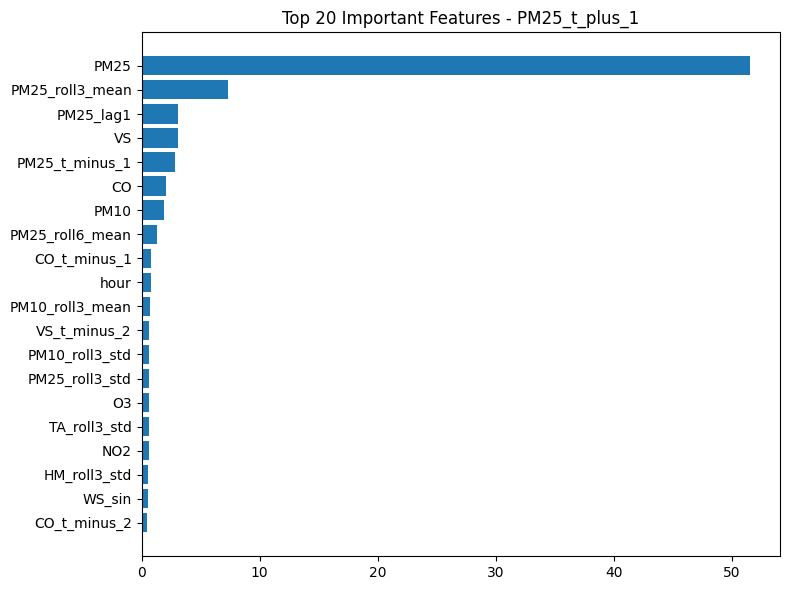

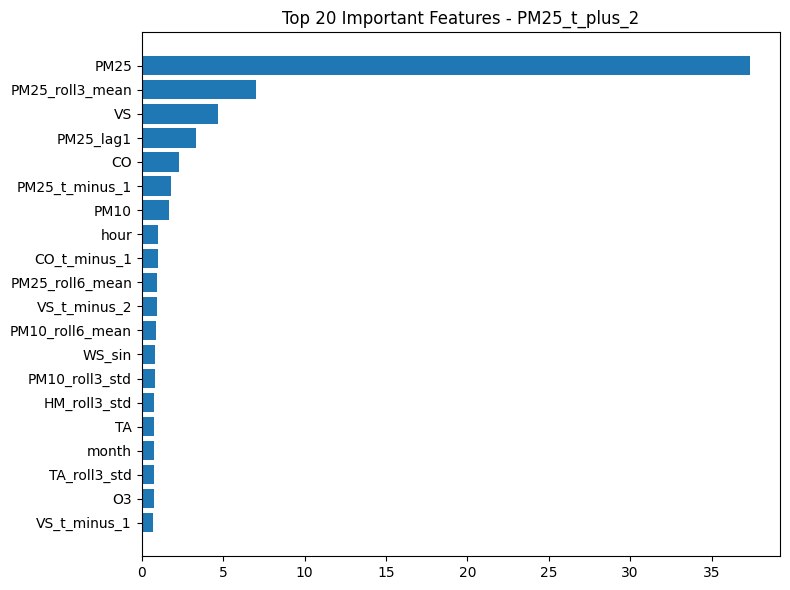

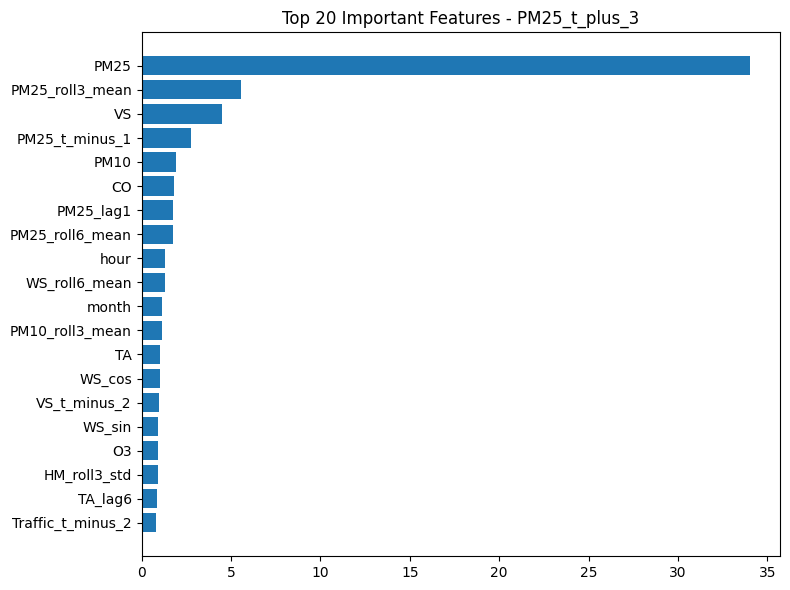

In [11]:
for tgt in TARGETS:
    model = models[tgt]
    imp = model.get_feature_importance()
    imp_df = pd.DataFrame({"feature": feature_cols, "importance": imp}) \
                 .sort_values("importance", ascending=False) \
                 .head(20)

    plt.figure(figsize=(8,6))
    plt.barh(imp_df["feature"][::-1], imp_df["importance"][::-1])
    plt.title(f"Top 20 Important Features - {tgt}")
    plt.tight_layout()
    plt.show()


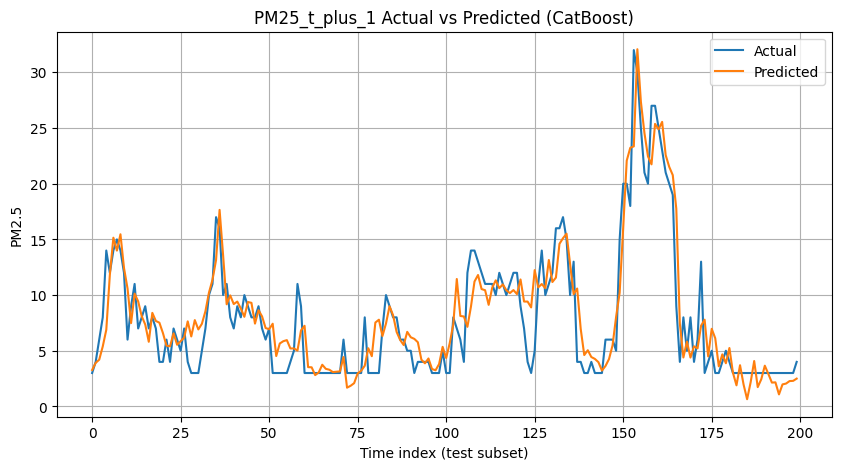

In [12]:
tgt = "PM25_t_plus_1"

mask_test = preds["split"] == "test"
y_true_test = preds.loc[mask_test, tgt].values
y_pred_test = preds.loc[mask_test, f"yhat_{tgt}"].values

plt.figure(figsize=(10,5))
plt.plot(y_true_test[:200], label="Actual")
plt.plot(y_pred_test[:200], label="Predicted")
plt.title(f"{tgt} Actual vs Predicted (CatBoost)")
plt.xlabel("Time index (test subset)")
plt.ylabel("PM2.5")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import joblib
import os

os.makedirs("artifacts", exist_ok=True)

joblib.dump(models, "artifacts/models_catboost.pkl")
joblib.dump(imputer, "artifacts/imputer_median.pkl")
joblib.dump(feature_cols, "artifacts/feature_cols.pkl")
joblib.dump(THRESH, "artifacts/threshold.pkl")

print("Saved:", os.listdir("artifacts"))

Saved: ['feature_cols.pkl', 'imputer_median.pkl', 'models_catboost.pkl', 'threshold.pkl']
